
Final Test Results:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        23
           2       1.00      1.00      1.00        12

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60



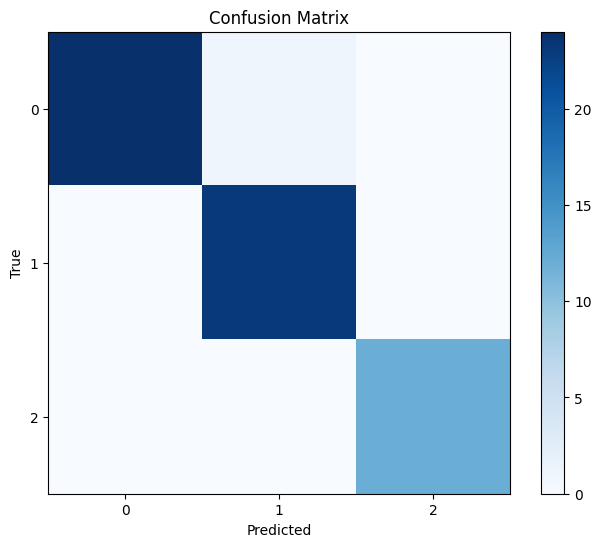

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. Генерация  данных
def make_balanced_data(samples_per_class=100, num_classes=3):
    torch.manual_seed(42)
    X = []
    y = []
    
    # Создаем четко разделимые кластеры
    for class_idx in range(num_classes):
        # Генерируем данные вокруг разных центров
        center = [class_idx * 3.0, -class_idx * 3.0]
        class_data = torch.randn(samples_per_class, 2) + torch.tensor(center)
        X.append(class_data)
        y.append(torch.full((samples_per_class,), class_idx))
    
    X = torch.cat(X)
    y = torch.cat(y)
    
   
    
    return X, y

#класс мультиклассификации
class BalancedClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes))
        
    def forward(self, x):
        return self.net(x)

# 3. Обучение с контролем баланса классов
def train_model():
    # Параметры
    num_classes = 3
    samples_per_class = 100
    batch_size = 32
    epochs = 100
    lr = 0.01
    
    # Данные
    X, y = make_balanced_data(samples_per_class, num_classes)
    
    # Разделение на train/test с сохранением баланса
    dataset = TensorDataset(X, y)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Модель
    model = BalancedClassifier(2, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Обучение
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Валидация
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                all_preds = []
                all_labels = []
                for batch_X, batch_y in test_loader:
                    outputs = model(batch_X)
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(batch_y.cpu().numpy())
                
                
    
    # Финальная оценка
    model.eval()
    with torch.no_grad():
        test_preds = []
        test_labels = []
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(batch_y.cpu().numpy())
        
        print("\nFinal Test Results:")
        print(classification_report(test_labels, test_preds, zero_division=0))
        
        # Confusion Matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(test_labels, test_preds)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        plt.xticks(range(num_classes), range(num_classes))
        plt.yticks(range(num_classes), range(num_classes))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

if __name__ == '__main__':
    train_model()